# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [4]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. Imports

In [7]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from darts import TimeSeries

%matplotlib inline

## 2. Load Dataset

In [8]:
df = pd.read_csv("../data/Copy of Sri_lanka_dengue_cases_weather_weekly_2007_2024_.csv")

In [9]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Month,Year,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Total Rain (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Weather Code,Avg Daylight Duration (hours),Avg Sunrise Time,Avg Sunset Time
0,Ampara,0,2007-01-01,1,2007,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,8.0,18.2000,44.3,3,11.714583,376,1079
1,Ampara,0,2007-01-08,1,2007,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,86.1,17.0250,43.6,53,11.733333,378,1082
2,Ampara,0,2007-01-15,1,2007,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,3.1,20.1875,48.2,51,11.754167,380,1085
3,Ampara,0,2007-01-22,1,2007,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,53.6,17.2000,42.5,61,11.783333,381,1088
4,Ampara,0,2007-01-29,1,2007,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,8.2,17.2625,40.0,51,11.812500,382,1090


In [10]:
len(df)

22900

In [11]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [12]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


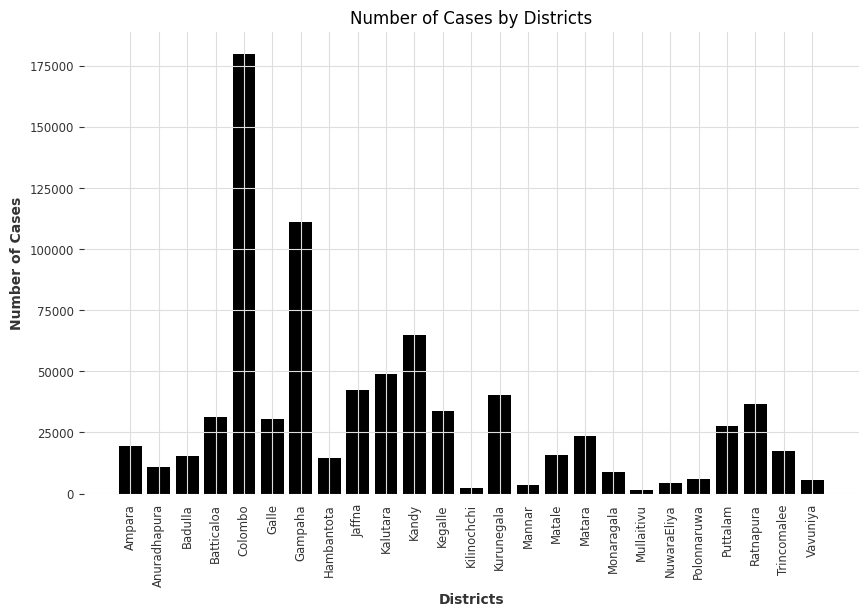

In [13]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.show()


## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [14]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [15]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Month,Year,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Total Rain (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Weather Code,Avg Daylight Duration (hours),Avg Sunrise Time,Avg Sunset Time
0,Ampara,0,2007-01-01,1,2007,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,8.0,18.2000,44.3,3,11.714583,376,1079
1,Ampara,0,2007-01-08,1,2007,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,86.1,17.0250,43.6,53,11.733333,378,1082
2,Ampara,0,2007-01-15,1,2007,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,3.1,20.1875,48.2,51,11.754167,380,1085
3,Ampara,0,2007-01-22,1,2007,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,53.6,17.2000,42.5,61,11.783333,381,1088
4,Ampara,0,2007-01-29,1,2007,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,8.2,17.2625,40.0,51,11.812500,382,1090


** The trend of cases of all 25 districts

In [16]:
# import plotly.express as px

# # List of all districts
# districts = df['District'].unique()

# for district in districts:
#     # Filter data for the current district
#     df_district = df[df['District'] == district]

#     # Create an interactive line plot using Plotly without markers
#     fig = px.line(
#         df_district,
#         x="Week_End_Date",
#         y="Number_of_Cases",
#         title=f"Number of Cases Over Time - {district}",
#         labels={'Week_End_Date': 'Week End Date', 'Number_of_Cases': 'Number of Cases'}
#     )

#     # Customize the layout for a bigger and clearer plot
#     fig.update_layout(
#         width=1000,  # Width of the figure
#         height=600,  # Height of the figure
#         title_font_size=18,
#         xaxis_title_font_size=14,
#         yaxis_title_font_size=14,
#         hovermode="x"  # Show hover data for the x-axis
#     )

#     # Show the interactive plot with zoom and pan features
#     fig.show()


## 5. Modelling
List of regression models.
- RegressionModel
- LinearRegressionModel
- RandomForest
- LightGBMModel
- XGBModel
- CatBoostModel



In [17]:
from darts.models import RegressionModel, RandomForest, LinearRegressionModel, XGBModel, LightGBMModel, CatBoostModel
from sklearn.linear_model import Ridge
from darts.metrics import rmse, mae, smape, r2_score, rmsle
import plotly.graph_objects as go

/home/surajkarki/Documents/My Workspace/Coding Works/Omdena_Sri_Lanka_Predicting_Dengue_Fever_Outbreak/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
!pip install "u8darts[all]"

In [1]:
reg = RegressionModel(
    lags = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags_future_covariates=[0],
    model = Ridge(),
    output_chunk_length=24,  # Number of time steps predicted at once (per chunk) by the internal model.
)
lr  = LinearRegressionModel(
    lags = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags_future_covariates=[0],
    output_chunk_length=24, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)

rf = RandomForest(
    lags = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags_future_covariates=[0],
    output_chunk_length=24, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)

lgbm = LightGBMModel(
    lags = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags_future_covariates=[0],
    output_chunk_length=24, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
xgb = XGBModel(
    lags = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags_future_covariates=[0],
    output_chunk_length=24, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
cat = CatBoostModel(
    lags = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags_future_covariates=[0],
    output_chunk_length=24, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)

NameError: name 'RegressionModel' is not defined

In [2]:
models = [reg, lr, rf, lgbm, xgb, cat]

NameError: name 'reg' is not defined

In [3]:
def save_model(model, model_name, district_name, folder):
    # Create directory if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Define the model file path
    model_file = os.path.join(folder, f'{district_name}_{model_name}.pt')

    # Save the model using pickle
    model.save(model_file)
    print(f"Model saved for {district_name}: {model_file}")

In [96]:
def train_and_forecast(train_series, val_series, future_covariates, model, district_name):
    model.fit(train_series, future_covariates=future_covariates)
    #model.fit(train_series)
    model_folder = f"./"
    # Save Model
    save_model(model, type(model).__name__, district_name, model_folder)

    # Forecast for the next 12 weeks
    forecast = model.predict(n=len(val_series), future_covariates=future_covariates)
    #forecast = model.predict(n=len(val_series))

    # Plot the results
    plt.figure(figsize=(12, 6))
    train_series.plot(label='Historical Data')
    val_series.plot(label='Validation Data', color='orange')
    forecast.plot(label='Forecast', color='green')
    plt.legend()
    plt.title(f"Forecast vs Validation for {district_name}")
    plt.show()

    # Calculate metrics
    val_values = val_series.values()
    forecast_values = forecast.values()

    # Ensure the forecast and validation values are the same length
    assert len(val_values) == len(forecast_values), "Forecast and validation series must have the same length for metrics calculation."

    # Compute metrics
    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series, forecast)
    error_smape = smape(val_series, forecast)
    error_rmsle = rmsle(val_series, forecast)

    errors = {
        "RMSE": error_rmse,
        "MAE": error_mae,
        "SMAPE": error_smape,
        "RMSLE": error_rmsle
    }
    results = [forecast, errors]
    return results

In [97]:
def main(data, models):
    districts = ["Jaffna"]
    final_output = []
    for district in districts:
      # Filter data for the specified district
      district_data = data[data['District'] == district]

      # Ensure the 'Week_End_Date' column is in datetime format
      district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

      # Prepare the data for ARIMA
      series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases', 'Avg Max Temp (°C)', "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Wind Speed (km/h)"])

      # Split series
      # Set aside the last 12 weeks as a validation series
      train_data, val_data = series["Number_of_Cases"][:-12], series["Number_of_Cases"][-12:]
      future_covariates = series[["Avg Max Temp (°C)", "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Wind Speed (km/h)"]]

      print(f"Training length: {len(train_data)}")
      print(f"Validation length: {len(val_data)}")

      district_output = []
      for m in models:
        result = train_and_forecast(train_data, val_data, future_covariates, m, district)
        district_output.append(result)

      final_output.append(district_output)

    return final_output


/tmp/ipykernel_40582/488231608.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training length: 904
Validation length: 12
Model saved for Matale: ./Matale_RegressionModel.pt


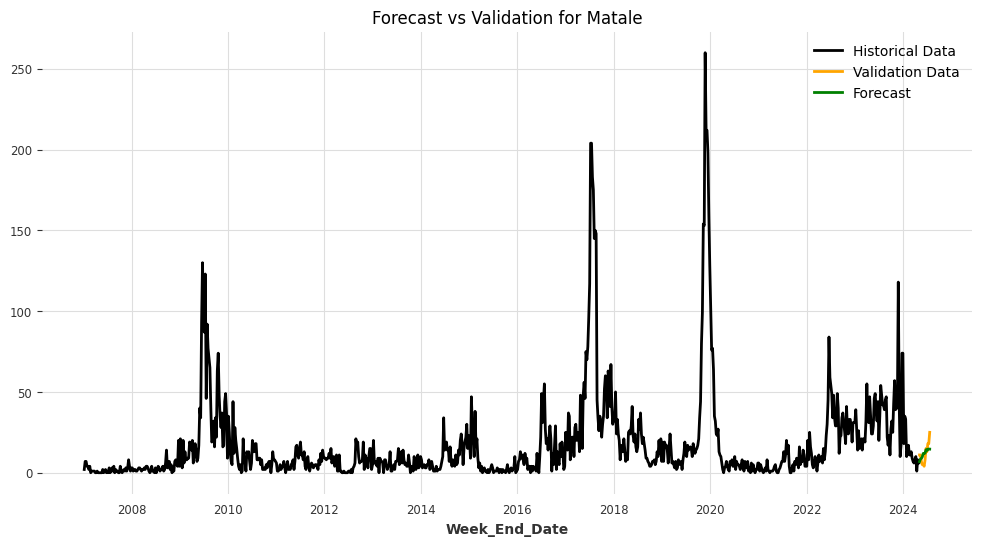

Model saved for Matale: ./Matale_LinearRegressionModel.pt


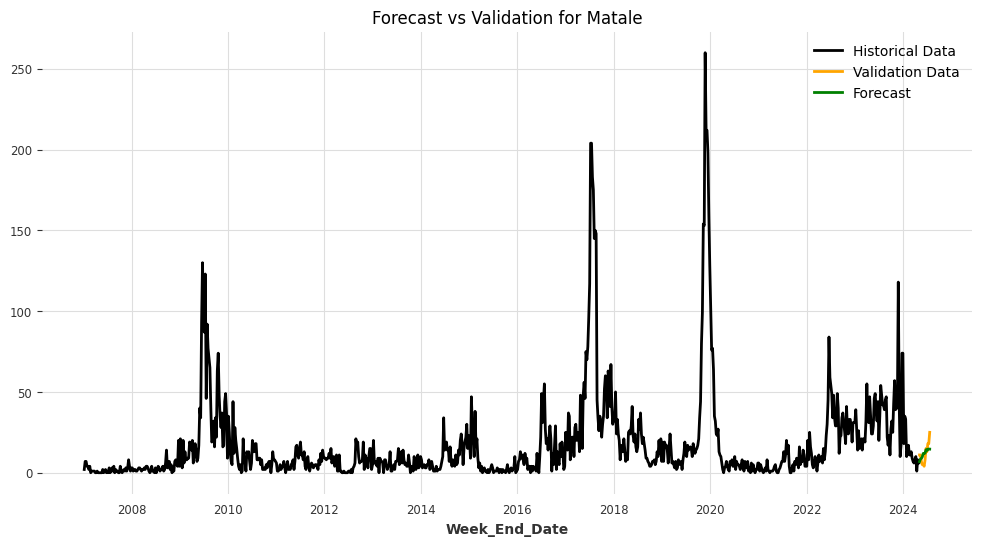

Model saved for Matale: ./Matale_RandomForest.pt


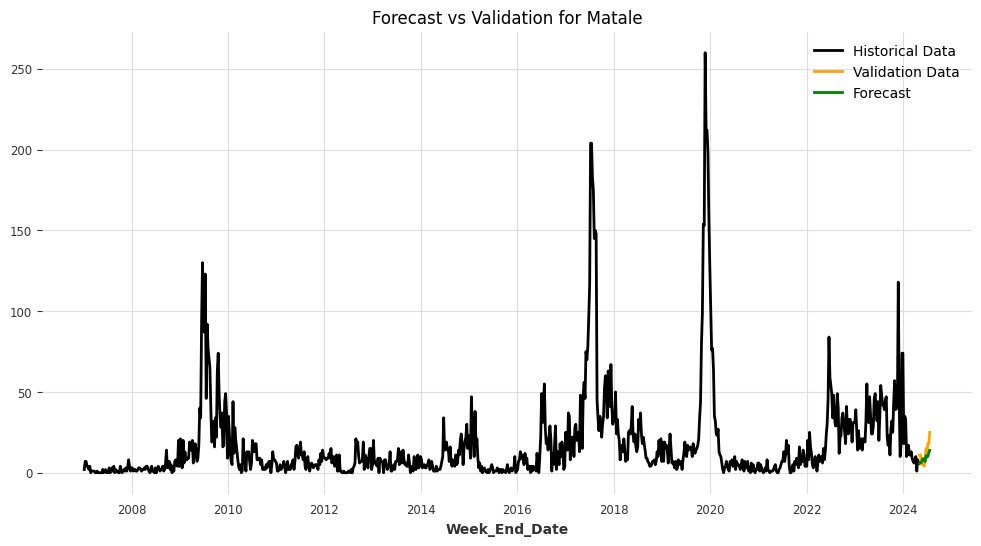

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 12
[LightGBM] [Info] Start training from score 17.185270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 12
[LightGBM] [Info] Start training from score 17.321059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the tra

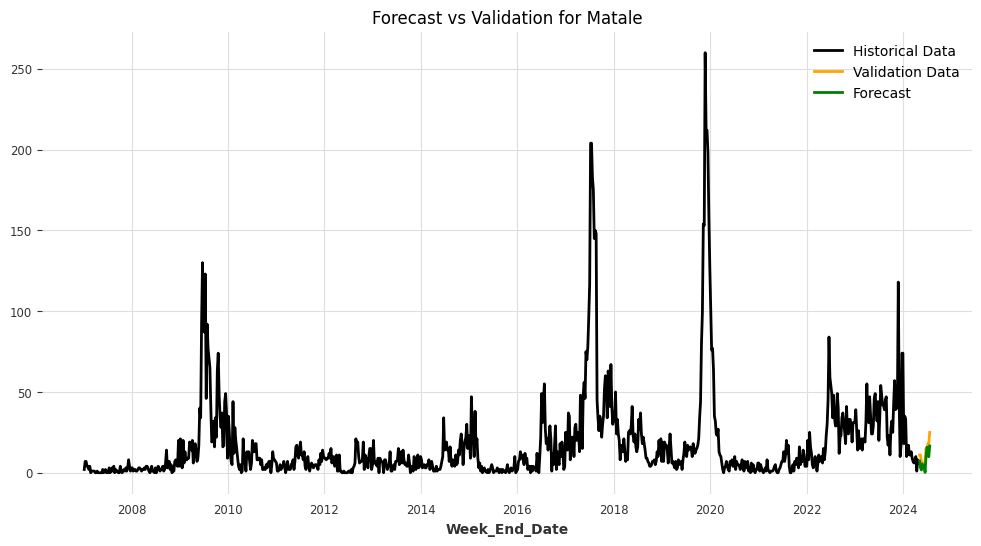

Model saved for Matale: ./Matale_XGBModel.pt


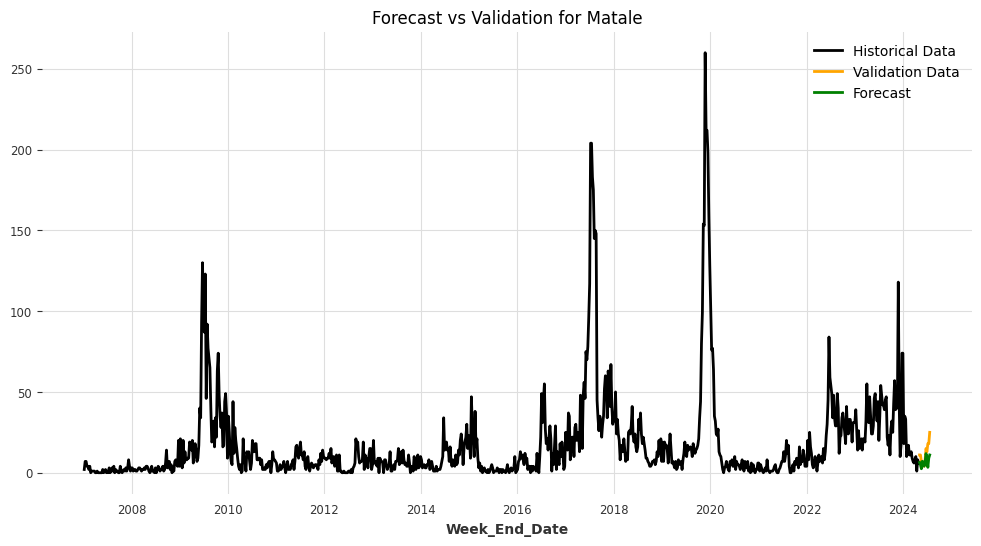

Model saved for Matale: ./Matale_CatBoostModel.pt


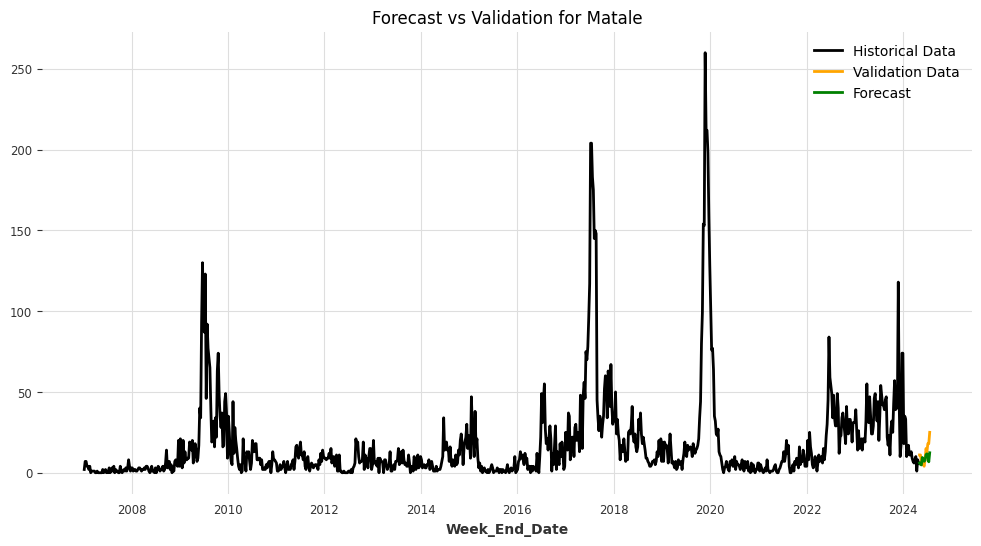

In [98]:
results = main(df, models)

## 6. Result

In [99]:
# Initialize a list to store metrics
metrics_list = []
districts = ["Jaffna"]

# Iterate over results and extract metrics
for district_index, district_results in enumerate(results):
    for model_index, (forecast, metrics) in enumerate(district_results):
        metrics_list.append({
            'District': f'{districts[district_index]}',
            'Model': type(models[model_index]).__name__,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'SMAPE': metrics['SMAPE'],
            'RMSLE': metrics['RMSLE']
        })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)
df_metrics.set_index(['District', 'Model'], inplace=True)

In [100]:
from IPython.display import display
from IPython.display import HTML

def display_district_metrics(df_metrics):
    districts = df_metrics.index.get_level_values('District').unique()

    for district in districts:
        print(f"Metrics for {district}:")
        district_df = df_metrics.loc[district]
        styled_df = district_df.style \
         .highlight_min(color="lightgreen", axis=0)

        display(styled_df)

# Example usage
display_district_metrics(df_metrics)


Metrics for Matale:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,5.091797,4.257692,40.722401,0.466573
LinearRegressionModel,5.091794,4.257687,40.722369,0.466573
RandomForest,5.356033,4.600833,43.963164,0.438781
LightGBMModel,5.383798,4.519075,58.021327,0.781986
XGBModel,7.082923,5.395129,53.800296,0.641664
CatBoostModel,6.143718,4.970863,48.269462,0.505583
